In [1]:
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

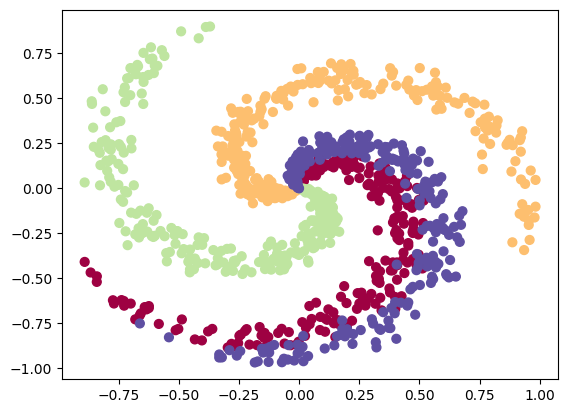

In [2]:
N = 250 # number of points per class
D = 2 # dimensionality
K = 4 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y)

X[:5], y[:5]

(tensor([[-0.0000, 0.0000],
         [0.0015, 0.0037],
         [0.0012, 0.0079],
         [0.0020, 0.0119],
         [0.0030, 0.0158]]),
 tensor([0, 0, 0, 0, 0], dtype=torch.uint8))

In [5]:
pd.Series(y.numpy()).nunique()

4

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state=57)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [7]:
class MultiClassClassificationModel(nn.Module):
    def __init__(self, input_features:int, class_number:int, hidden_units= 8):
        """
        Args:
            in_features (int): Number of input features to the model.
            class_number (int): Number of output features of the model (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8
        """

        super().__init__()

        self.layer1 = nn.Linear(in_features=input_features, out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units, out_features=hidden_units*2)
        self.layer3 = nn.Linear(in_features=hidden_units*2, out_features=hidden_units)
        self.out = nn.Linear(in_features=hidden_units, out_features= class_number)
        self.relu = nn.ReLU()


    def forward(self, X:torch.Tensor) -> torch.Tensor:
        z = self.layer1(X)
        z = self.relu(self.layer2(z))
        z = self.relu(self.layer3(z))
        z = self.out(z)
        return z

In [8]:
model_0 = MultiClassClassificationModel(input_features=2, class_number=6).to(device)
model_0

MultiClassClassificationModel(
  (layer1): Linear(in_features=2, out_features=8, bias=True)
  (layer2): Linear(in_features=8, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=8, bias=True)
  (out): Linear(in_features=8, out_features=6, bias=True)
  (relu): ReLU()
)

In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.06)

In [10]:
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

In [11]:
y_logits = model_0(X_train)
y_pred_probs = torch.softmax(y_logits, dim=1)

y_logits[:5], y_pred_probs[:5], torch.sum(y_pred_probs[0])

(tensor([[ 0.0422, -0.1132,  0.3429, -0.0190,  0.2675, -0.3827],
         [ 0.0421, -0.1132,  0.3430, -0.0189,  0.2669, -0.3828],
         [ 0.0424, -0.1025,  0.3056, -0.0217,  0.2570, -0.3629],
         [ 0.0427, -0.1157,  0.3329, -0.0193,  0.2675, -0.3837],
         [ 0.0456, -0.0886,  0.2934, -0.0247,  0.2547, -0.3507]],
        device='cuda:0', grad_fn=<SliceBackward0>),
 tensor([[0.1652, 0.1414, 0.2231, 0.1554, 0.2069, 0.1080],
         [0.1652, 0.1414, 0.2232, 0.1554, 0.2068, 0.1080],
         [0.1664, 0.1439, 0.2165, 0.1561, 0.2062, 0.1109],
         [0.1657, 0.1414, 0.2215, 0.1557, 0.2075, 0.1082],
         [0.1669, 0.1459, 0.2138, 0.1555, 0.2057, 0.1123]], device='cuda:0',
        grad_fn=<SliceBackward0>),
 tensor(1., device='cuda:0', grad_fn=<SumBackward0>))

In [12]:
torch.manual_seed(57)

train_loss_list = []
test_loss_list = []
train_accuracy_list = []
test_accuracy_list = []
epoch_counts = []

"""best_loss = float("inf")
patience = 50
counter = 0"""

epochs = 5000

for epoch in range(epochs):

    model_0.train()

    y_logits = model_0(X_train)
    y_preds = torch.softmax(y_logits, dim=1).argmax(dim=1)

    train_loss = criterion(y_logits, y_train)
    train_acc = accuracy_score(y_pred=y_preds.cpu().numpy(), y_true=y_train.cpu().numpy())

    optimizer.zero_grad()

    train_loss.backward()

    optimizer.step()

    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test)
        test_preds = torch.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = criterion(test_logits, y_test)
        test_acc = accuracy_score(y_pred=test_preds.cpu().numpy(), y_true=y_test.cpu().numpy())

        """if test_loss < best_loss:
            best_loss = test_loss
            counter = 0
        
        else:
            counter += 1
        
        if counter >= patience:
            print(f"EARLY STOPPING at epoch {epoch}")
            break"""
    
    if epoch % 10 == 0:
        train_loss_list.append(train_loss.detach().cpu().numpy())
        test_loss_list.append(test_loss.detach().cpu().numpy())
        train_accuracy_list.append(train_acc)
        test_accuracy_list.append(test_acc)
        epoch_counts.append(epoch)

        print(f"{epoch} ---> Train Loss: {train_loss.item():.4f} && Test Loss: {test_loss.item():.4f} && Accuracy: {test_acc:.4f}")
    
print("DONE!")

0 ---> Train Loss: 1.7796 && Test Loss: 1.6767 && Accuracy: 0.2100
10 ---> Train Loss: 1.1966 && Test Loss: 1.1704 && Accuracy: 0.3700
20 ---> Train Loss: 0.9216 && Test Loss: 0.8931 && Accuracy: 0.5250
30 ---> Train Loss: 0.6853 && Test Loss: 0.6384 && Accuracy: 0.7050
40 ---> Train Loss: 0.5600 && Test Loss: 0.5935 && Accuracy: 0.7300
50 ---> Train Loss: 0.4292 && Test Loss: 0.4395 && Accuracy: 0.8350
60 ---> Train Loss: 0.3490 && Test Loss: 0.3821 && Accuracy: 0.8550
70 ---> Train Loss: 0.2675 && Test Loss: 0.3171 && Accuracy: 0.8750
80 ---> Train Loss: 0.2438 && Test Loss: 0.5231 && Accuracy: 0.8800
90 ---> Train Loss: 0.3141 && Test Loss: 0.2214 && Accuracy: 0.9000
100 ---> Train Loss: 0.2243 && Test Loss: 0.1830 && Accuracy: 0.9000
110 ---> Train Loss: 0.2222 && Test Loss: 0.1944 && Accuracy: 0.9350
120 ---> Train Loss: 0.1983 && Test Loss: 0.2411 && Accuracy: 0.9400
130 ---> Train Loss: 0.1698 && Test Loss: 0.2617 && Accuracy: 0.9350
140 ---> Train Loss: 0.1575 && Test Loss: 0.2

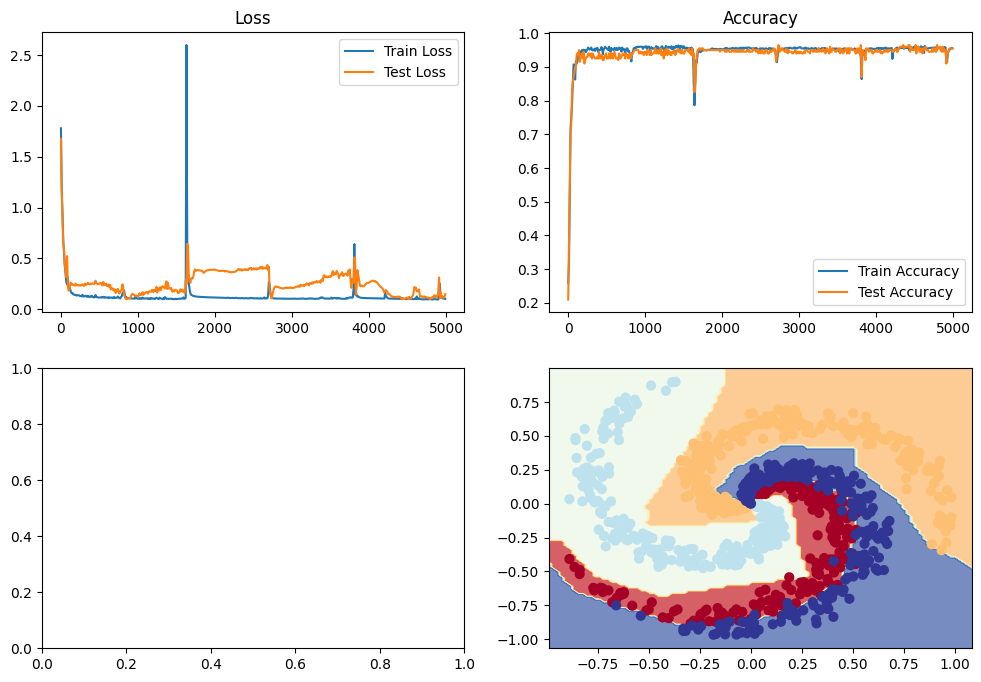

In [17]:
fig, axs = plt.subplots(2,2, figsize=(12,8))
axs = axs.flatten()

axs[0].plot(epoch_counts,train_loss_list, label="Train Loss")
axs[0].plot(epoch_counts, test_loss_list,  label="Test Loss")
axs[0].set_title("Loss")
axs[0].legend()

axs[1].plot(epoch_counts, train_accuracy_list, label="Train Accuracy")
axs[1].plot(epoch_counts, test_accuracy_list, label="Test Accuracy")
axs[1].set_title("Accuracy")
axs[1].legend()

from helper_functions import plot_decision_boundary
plot_decision_boundary(model=model_0, X=X, y=y)

plt.show()